In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

In [2]:
df = pd.read_csv("hospital_synth.csv", sep=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315648 entries, 0 to 315647
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   timestamp_admission   315648 non-null  object 
 1   Service               315648 non-null  object 
 2   Nombre_Admissions     315648 non-null  int64  
 3   motif_admission       315648 non-null  object 
 4   gravite               315648 non-null  int64  
 5   duree_sejour_estimee  315648 non-null  float64
 6   type_lit_requis       315648 non-null  object 
 7   facteur_externe       315648 non-null  object 
 8   Lits_Occupes          315648 non-null  int64  
 9   Lits_Disponibles      315648 non-null  int64  
 10  Personnel_Present     315648 non-null  int64  
 11  Stock_EPI             315648 non-null  int64  
 12  EPI_Consommation      315648 non-null  int64  
 13  Rupture_Stock         315648 non-null  int64  
 14  Indicateur_Epidemie   315648 non-null  int64  
 15  

In [4]:
# 1. Typage
df['timestamp_admission'] = pd.to_datetime(df['timestamp_admission'])

# 2. Segmentation
df_urgences = df[df['Service'] == 'Urgences'].copy()

# 3. Resampling (Rythme imposé)
# On agrège par heure pour avoir une série temporelle propre.
# 'sum' pour les admissions, 'max' pour les indicateurs (s'il y a grève à 14h15, il y a grève à 14h00).
df_prepared = df_urgences.set_index('timestamp_admission').resample('h').agg({
    'Nombre_Admissions': 'sum',
    'Indicateur_Epidemie': 'max',
    'Indicateur_Canicule': 'max',
    'Indicateur_Greve': 'max'
}).reset_index()

# 4. Traduction pour Prophet
df_prophet = df_prepared.rename(columns={
    'timestamp_admission': 'ds', # Le temps
    'Nombre_Admissions': 'y'     # Le signal à prédire
})

# 5. La Coupure Temporelle (Train vs Test)
cutoff_date = '2025-01-01'
train = df_prophet[df_prophet['ds'] < cutoff_date]
test = df_prophet[df_prophet['ds'] >= cutoff_date]

print(f"Mémoire d'entraînement (Train): {train.shape[0]} heures")
print(f"Futur à prédire (Test): {test.shape[0]} heures")
print(train.head())

Mémoire d'entraînement (Train): 43848 heures
Futur à prédire (Test): 8760 heures
                   ds  y  Indicateur_Epidemie  Indicateur_Canicule  \
0 2020-01-01 00:00:00  7                    0                    0   
1 2020-01-01 01:00:00  3                    0                    0   
2 2020-01-01 02:00:00  8                    0                    0   
3 2020-01-01 03:00:00  6                    0                    0   
4 2020-01-01 04:00:00  9                    0                    0   

   Indicateur_Greve  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  


In [10]:
m = Prophet(
    # On coupe la gestion auto pour la gérer manuellement avec plus de finesse
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,

    # LEVIER 1 : Flexibilité de la tendance
    # Permet au modèle de changer de direction plus vite (Trend plus réactif)
    changepoint_prior_scale=0.1,

    # LEVIER 2 : Force de la saisonnalité
    # Autorise des fluctuations saisonnières de grande amplitude
    seasonality_prior_scale=10.0
)

# LEVIER 3 : Haute Résolution Temporelle (Fourier Order)
# daily period=1. fourier_order=20 permet de capter des pics très brefs dans la journée.
m.add_seasonality(name='daily', period=1, fourier_order=20)

# On rajoute la semaine aussi avec plus de détails (le week-end est spécifique)
m.add_seasonality(name='weekly', period=7, fourier_order=10)

m.add_regressor('Indicateur_Epidemie')
m.add_regressor('Indicateur_Canicule')
m.add_regressor('Indicateur_Greve')

# On ne lui donne que le passé (Train).
print("Début de l'entraînement...")
m.fit(train)

Début de l'entraînement...


15:20:13 - cmdstanpy - INFO - Chain [1] start processing
15:20:27 - cmdstanpy - INFO - Chain [1] done processing


--- Performance de Prophet ---
MAE: 2.65
RMSE: 3.37


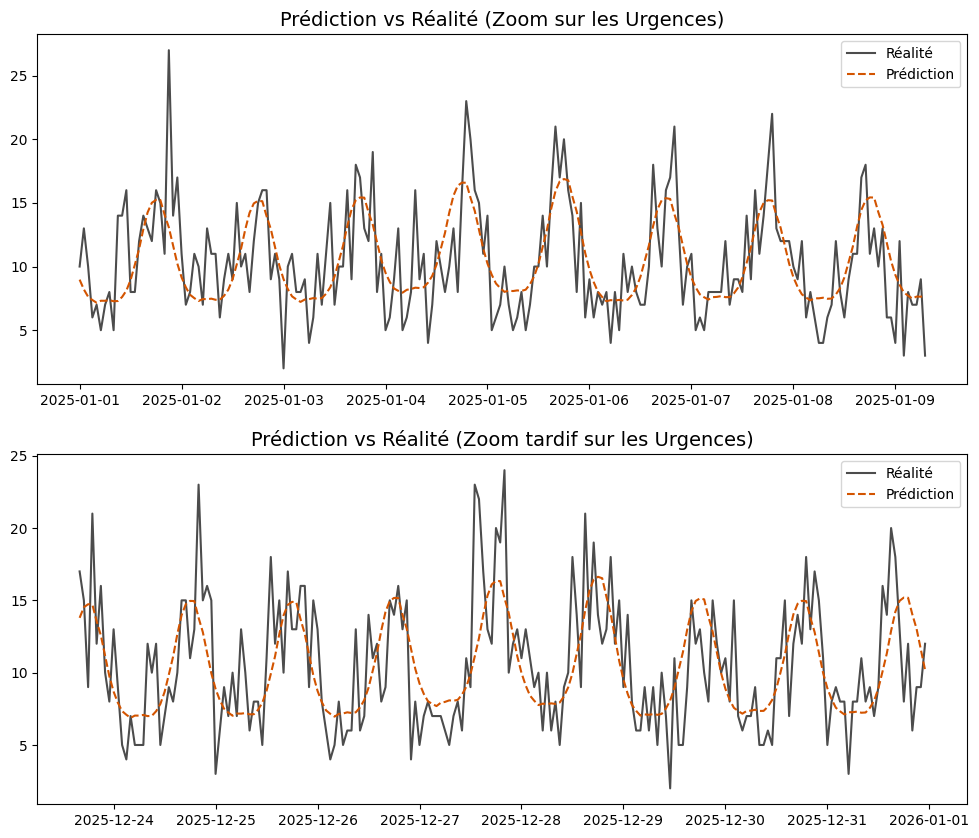

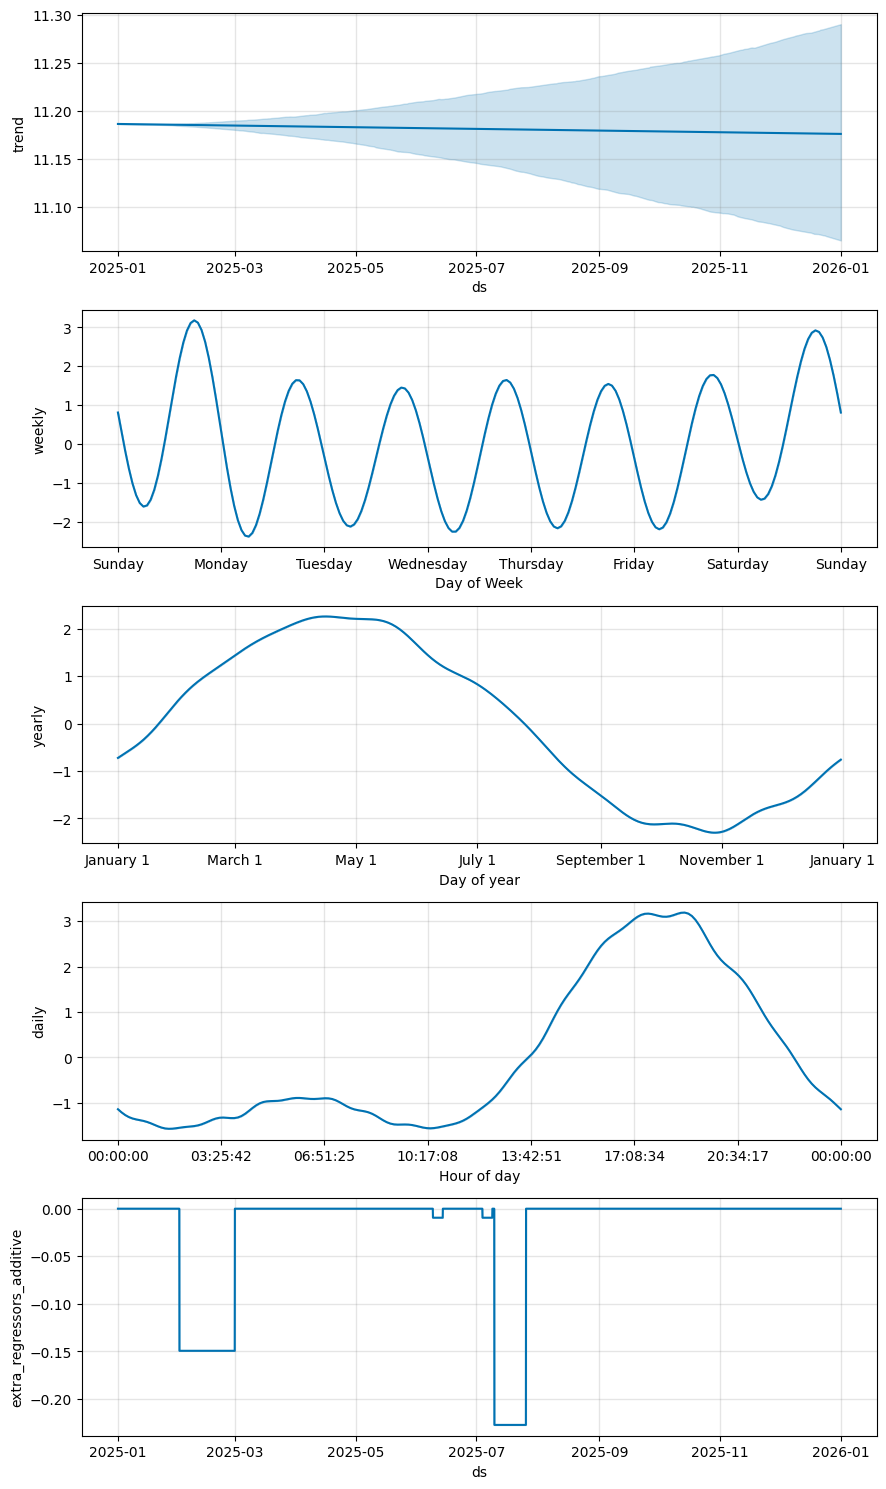

In [11]:
# On demande au modèle de prédire sur le dataset de Test.
# Note : Prophet a besoin des régresseurs futurs pour prédire le futur !
forecast = m.predict(test)

# On compare 'yhat' (la prédiction) avec 'y' (la vérité du testset)
y_true = test['y'].values
y_pred = forecast['yhat'].values

# Métriques de performance
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"--- Performance de Prophet ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Visualisation
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
# On zoome sur une fenêtre courte (ex: 200 heures) pour voir les détails
limit = 200
axs[0].plot(test['ds'].iloc[:limit], y_true[:limit], label='Réalité', color='black', alpha=0.7)
axs[0].plot(test['ds'].iloc[:limit], y_pred[:limit], label='Prédiction', color='#D35400', linestyle='--')
axs[0].set_title('Prédiction vs Réalité (Zoom sur les Urgences)', fontsize=14)
axs[0].legend()
# On zoome sur une fenêtre courte mais plus tard dans le temps (à la fin du test)
axs[1].plot(test['ds'].iloc[-limit:], y_true[-limit:], label='Réalité', color='black', alpha=0.7)
axs[1].plot(test['ds'].iloc[-limit:], y_pred[-limit:], label='Prédiction', color='#D35400', linestyle='--')
axs[1].set_title('Prédiction vs Réalité (Zoom tardif sur les Urgences)', fontsize=14)
axs[1].legend()

plt.show()

# Bonus : Voir les composants (L'anatomie de la décision)
fig2 = m.plot_components(forecast)

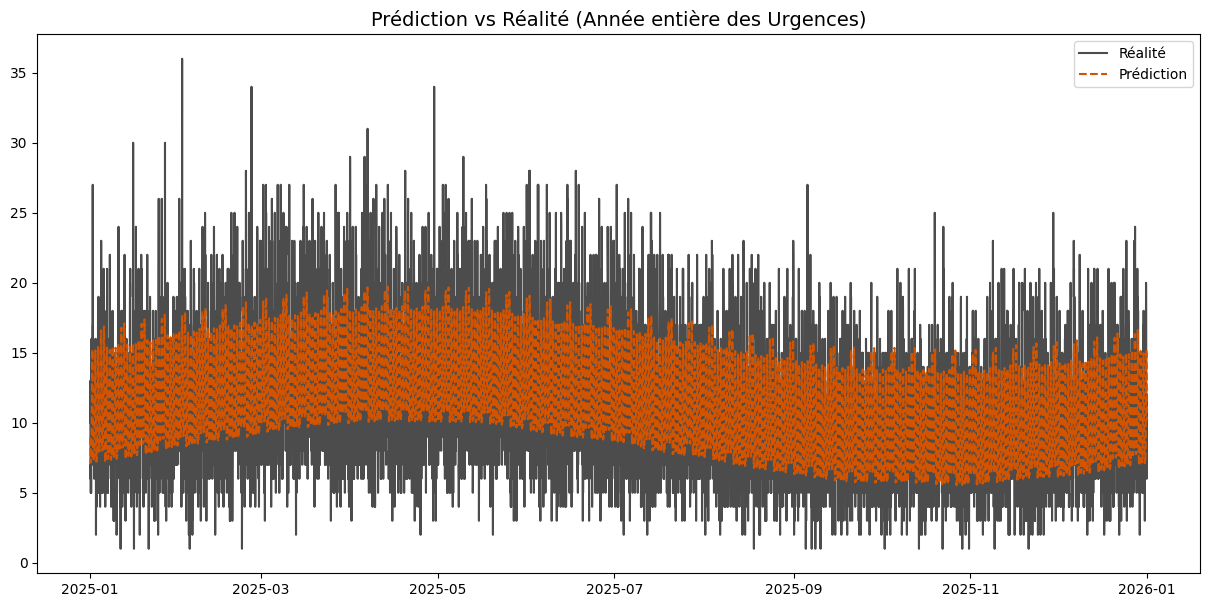

In [12]:
# plot pour montrer comment le modèle gère l'année entière (on dézoome)
plt.figure(figsize=(15, 7))
plt.plot(test['ds'], y_true, label='Réalité', color='black', alpha=0.7)
plt.plot(test['ds'], y_pred, label='Prédiction', color='#D35400', linestyle='--')
plt.title('Prédiction vs Réalité (Année entière des Urgences)', fontsize=14)
plt.legend()
plt.show()

In [16]:
# 1. Chargement
df_urgences = df[df['Service'] == 'Urgences'].copy()

# Resampling Horaire
df_prepared = df_urgences.set_index('timestamp_admission').resample('h').agg({
    'Nombre_Admissions': 'sum',
    'Indicateur_Epidemie': 'max',
    'Indicateur_Canicule': 'max',
    'Indicateur_Greve': 'max'
}).reset_index()

# --- 2. Feature Engineering Avancé (La clé du succès) ---

# A. Extraction basique
df_prepared['hour'] = df_prepared['timestamp_admission'].dt.hour
df_prepared['dayofweek'] = df_prepared['timestamp_admission'].dt.dayofweek
df_prepared['month'] = df_prepared['timestamp_admission'].dt.month
df_prepared['year'] = df_prepared['timestamp_admission'].dt.year

# B. Encodage Cyclique (Pour que le modèle comprenne que 23h ~ 00h)
# C'est de la géométrie temporelle.
df_prepared['hour_sin'] = np.sin(2 * np.pi * df_prepared['hour'] / 24)
df_prepared['hour_cos'] = np.cos(2 * np.pi * df_prepared['hour'] / 24)
df_prepared['month_sin'] = np.sin(2 * np.pi * df_prepared['month'] / 12)
df_prepared['month_cos'] = np.cos(2 * np.pi * df_prepared['month'] / 12)

# C. La Mémoire (Lags)
# "Combien de gens sont arrivés il y a une heure ? Hier à la même heure ?"
df_prepared['lag_1h'] = df_prepared['Nombre_Admissions'].shift(1)
df_prepared['lag_2h'] = df_prepared['Nombre_Admissions'].shift(2)
df_prepared['lag_24h'] = df_prepared['Nombre_Admissions'].shift(24) # Rythme circadien
df_prepared['lag_168h'] = df_prepared['Nombre_Admissions'].shift(168) # Rythme hebdo

# D. Statistiques Glissantes (Rolling Window)
# "Tendance récente sur 3 heures"
df_prepared['rolling_mean_3h'] = df_prepared['Nombre_Admissions'].shift(1).rolling(window=3).mean()

# Nettoyage des NaN créés par les lags
df_model = df_prepared.dropna()

# --- 3. Train / Test Split ---
cutoff_date = '2025-01-01'
train = df_model[df_model['timestamp_admission'] < cutoff_date]
test = df_model[df_model['timestamp_admission'] >= cutoff_date]

# Définition des features (On enlève le timestamp et la cible)
features = [
    'Indicateur_Epidemie', 'Indicateur_Canicule', 'Indicateur_Greve',
    'hour_sin', 'hour_cos', 'dayofweek', 'month_sin', 'month_cos',
    'lag_1h', 'lag_2h', 'lag_24h', 'lag_168h', 'rolling_mean_3h'
]
target = 'Nombre_Admissions'

In [17]:
# --- Le Modèle XGBoost ---
print("Initialisation du Booster...")
model = xgb.XGBRegressor(
    n_estimators=1000,      # Nombre d'arbres (le comité d'experts)
    learning_rate=0.05,     # Vitesse d'apprentissage (doucement mais sûrement)
    max_depth=5,            # Complexité de chaque arbre
    early_stopping_rounds=50, # Arrête si ça ne s'améliore plus
    n_jobs=-1,
    random_state=42
)

# Entraînement avec validation set pour l'early stopping
model.fit(
    train[features], train[target],
    eval_set=[(train[features], train[target]), (test[features], test[target])],
    verbose=100 # Affiche le progrès tous les 100 arbres
)

Initialisation du Booster...
[0]	validation_0-rmse:4.68297	validation_1-rmse:4.70583
[100]	validation_0-rmse:3.32244	validation_1-rmse:3.35798
[146]	validation_0-rmse:3.30647	validation_1-rmse:3.35953


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)


--- Performance XGBoost ---
MAE: 2.65
RMSE: 3.36


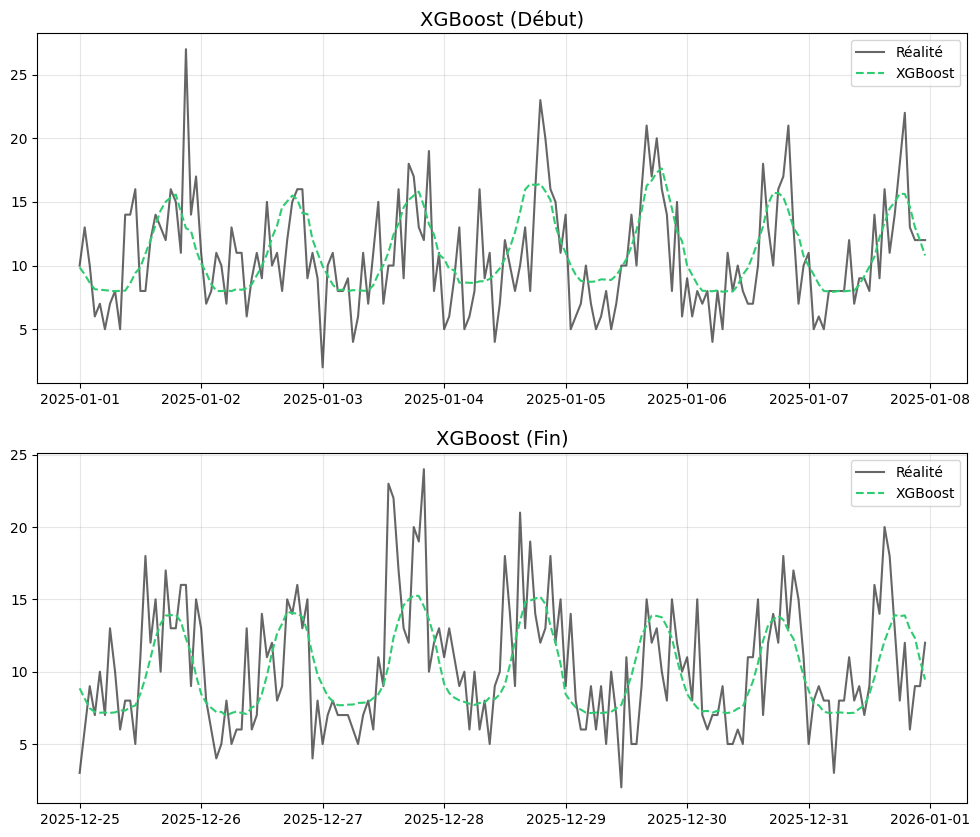

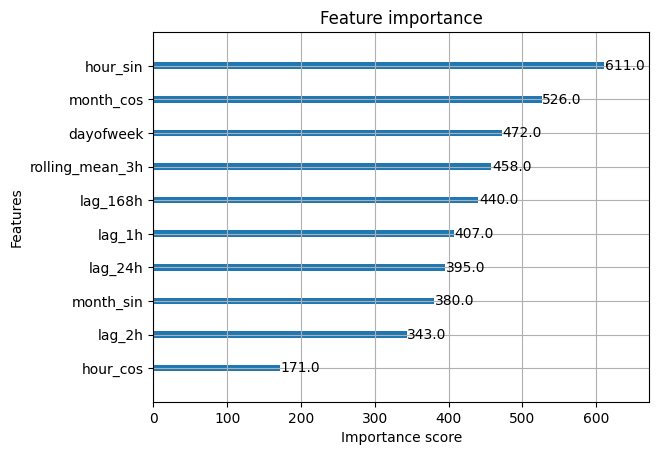

In [19]:

# --- Prédiction & Évaluation ---
predictions = model.predict(test[features])
# On empêche les prédictions négatives
predictions = np.maximum(predictions, 0)

mae = mean_absolute_error(test[target], predictions)
rmse = np.sqrt(mean_squared_error(test[target], predictions))

print(f"\n--- Performance XGBoost ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Visualisation Zoom, au début du test et à la fin
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
limit = 168 # Une semaine
# début
axs[0].plot(test['timestamp_admission'].iloc[:limit], test[target].iloc[:limit], label='Réalité', color='black', alpha=0.6)
axs[0].plot(test['timestamp_admission'].iloc[:limit], predictions[:limit], label='XGBoost', color='#2ECC71', linestyle='--') # Vert Matrix
axs[0].set_title('XGBoost (Début)', fontsize=14)
axs[0].legend()
axs[0].grid(True, alpha=0.3)
# fin
axs[1].plot(test['timestamp_admission'].iloc[-limit:], test[target].iloc[-limit:], label='Réalité', color='black', alpha=0.6)
axs[1].plot(test['timestamp_admission'].iloc[-limit:], predictions[-limit:], label='XGBoost', color='#2ECC71', linestyle='--') # Vert Matrix
axs[1].set_title('XGBoost (Fin)', fontsize=14)
axs[1].legend()
axs[1].grid(True, alpha=0.3)
plt.show()

# Feature Importance (Pour comprendre le cerveau de la machine)
xgb.plot_importance(model, max_num_features=10)
plt.show()

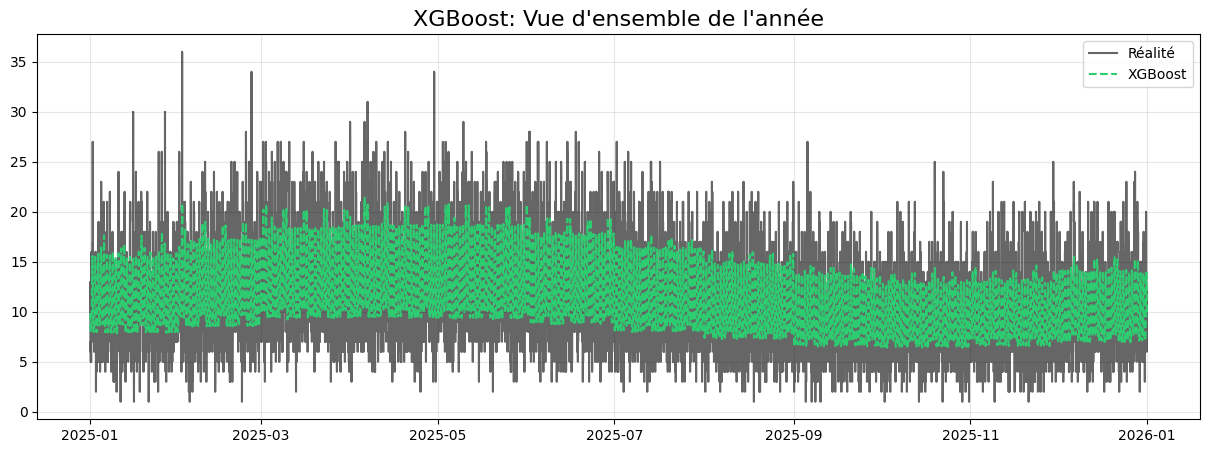

In [20]:
# plot pour montrer comment XGBoost gère l'année entière (on dézoome)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test['timestamp_admission'], test[target], label='Réalité', color='black', alpha=0.6)
ax.plot(test['timestamp_admission'], predictions, label='XGBoost', color='#2ECC71', linestyle='--') # Vert Matrix
ax.set_title("XGBoost: Vue d'ensemble de l'année", fontsize=16)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

>>> Activation du lobe temporal (Prophet)...


15:50:11 - cmdstanpy - INFO - Chain [1] start processing
15:50:23 - cmdstanpy - INFO - Chain [1] done processing


>>> Activation du réflexe correctif (XGBoost)...

--- RÉSULTAT Prophet (En solo) ---
MAE: 2.65
RMSE: 3.37

--- RÉSULTAT HYBRIDE (La Chimère) ---
MAE: 2.66
RMSE: 3.37


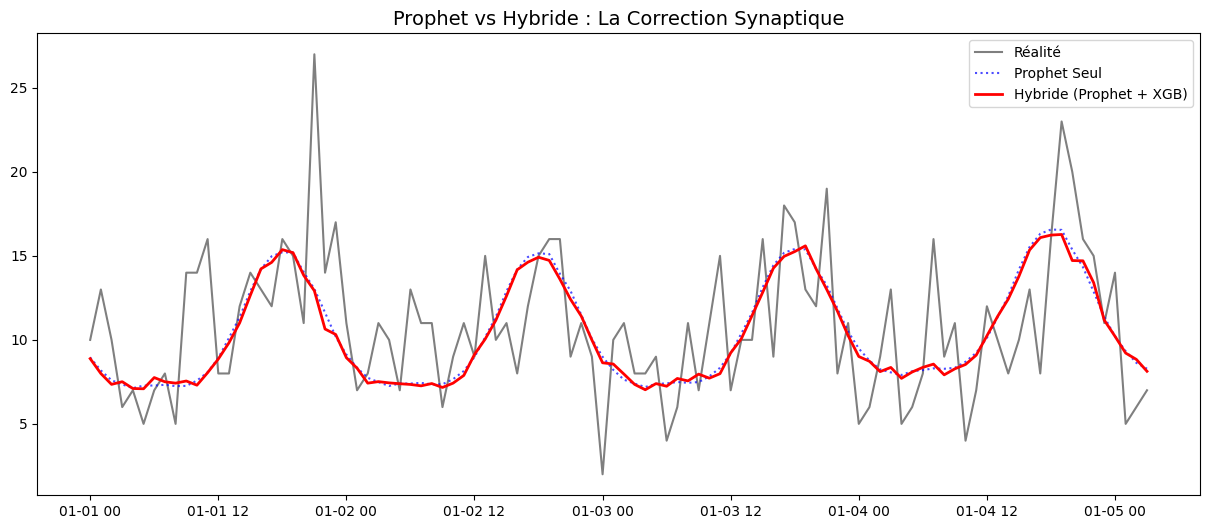

In [25]:
import pandas as pd
import numpy as np
import xgboost as xgb
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# --- 1. Préparation des Données (Standard) ---
# 1. Typage
df['timestamp_admission'] = pd.to_datetime(df['timestamp_admission'])

# 2. Segmentation
df_urgences = df[df['Service'] == 'Urgences'].copy()

# 3. Resampling (Rythme imposé)
# On agrège par heure pour avoir une série temporelle propre.
# 'sum' pour les admissions, 'max' pour les indicateurs (s'il y a grève à 14h15, il y a grève à 14h00).
df_prepared = df_urgences.set_index('timestamp_admission').resample('h').agg({
    'Nombre_Admissions': 'sum',
    'Indicateur_Epidemie': 'max',
    'Indicateur_Canicule': 'max',
    'Indicateur_Greve': 'max'
}).reset_index()

# 4. Traduction pour Prophet
df_prepared = df_prepared.rename(columns={
    'timestamp_admission': 'ds', # Le temps
    'Nombre_Admissions': 'y'     # Le signal à prédire
})

# --- 2. Feature Engineering Avancé (La clé du succès) ---

# A. Extraction basique
df_prepared['hour'] = df_prepared['ds'].dt.hour
df_prepared['dayofweek'] = df_prepared['ds'].dt.dayofweek
df_prepared['month'] = df_prepared['ds'].dt.month
df_prepared['year'] = df_prepared['ds'].dt.year

# B. Encodage Cyclique (Pour que le modèle comprenne que 23h ~ 00h)
# C'est de la géométrie temporelle.
df_prepared['hour_sin'] = np.sin(2 * np.pi * df_prepared['hour'] / 24)
df_prepared['hour_cos'] = np.cos(2 * np.pi * df_prepared['hour'] / 24)
df_prepared['month_sin'] = np.sin(2 * np.pi * df_prepared['month'] / 12)
df_prepared['month_cos'] = np.cos(2 * np.pi * df_prepared['month'] / 12)

# C. La Mémoire (Lags)
# "Combien de gens sont arrivés il y a une heure ? Hier à la même heure ?"
df_prepared['lag_1h'] = df_prepared['y'].shift(1)
df_prepared['lag_2h'] = df_prepared['y'].shift(2)
df_prepared['lag_24h'] = df_prepared['y'].shift(24) # Rythme circadien
df_prepared['lag_168h'] = df_prepared['y'].shift(168) # Rythme hebdo

# D. Statistiques Glissantes (Rolling Window)
# "Tendance récente sur 3 heures"
df_prepared['rolling_mean_3h'] = df_prepared['y'].shift(1).rolling(window=3).mean()

# Nettoyage des NaN créés par les lags
df_model = df_prepared.dropna()

# --- 3. Train / Test Split ---
cutoff_date = '2025-01-01'
train = df_model[df_model['ds'] < cutoff_date]
test = df_model[df_model['ds'] >= cutoff_date]

# Définition des features (On enlève le timestamp et la cible)
features = [
    'Indicateur_Epidemie', 'Indicateur_Canicule', 'Indicateur_Greve',
    'hour_sin', 'hour_cos', 'dayofweek', 'month_sin', 'month_cos',
    'lag_1h', 'lag_2h', 'lag_24h', 'lag_168h', 'rolling_mean_3h'
]
target = 'y'

# --- 2. ÉTAPE 1 : Le Prophète (Base Model) ---
print(">>> Activation du lobe temporal (Prophet)...")
m = Prophet(
    daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True,
    changepoint_prior_scale=0.1, seasonality_prior_scale=10.0
)
m.add_seasonality(name='daily', period=1, fourier_order=15)
m.add_seasonality(name='weekly', period=7, fourier_order=10)
m.add_regressor('Indicateur_Epidemie')
m.add_regressor('Indicateur_Canicule')
m.add_regressor('Indicateur_Greve')

m.fit(train)

# Prédictions de base
forecast_train = m.predict(train)
forecast_test = m.predict(test)

# --- 3. Calcul des Résidus (Ce que Prophet n'a pas compris) ---
# Résidu = Réalité - Prédiction Prophet
y_train_residuals = train['y'].values - forecast_train['yhat'].values

# --- 4. ÉTAPE 2 : Le Correcteur (XGBoost sur les Résidus) ---
print(">>> Activation du réflexe correctif (XGBoost)...")

# On utilise les features "court terme" pour corriger
xgb_features = [
    'lag_1h', 'lag_24h', 'rolling_mean_3h', # La mémoire immédiate
    'Indicateur_Epidemie', 'Indicateur_Greve' # Le contexte
]

xgb_corrector = xgb.XGBRegressor(
    n_estimators=500, max_depth=4, learning_rate=0.05, n_jobs=-1, random_state=42
)

# ATTENTION : On entraîne XGBoost à prédire l'ERREUR (residuals), pas le nombre d'admissions !
xgb_corrector.fit(train[xgb_features], y_train_residuals)

# --- 5. La Fusion (Prediction Finale) ---
# A. Prophet prédit le futur
prophet_pred = forecast_test['yhat'].values

# B. XGBoost prédit de combien Prophet va se tromper
correction_pred = xgb_corrector.predict(test[xgb_features])

# C. Somme des deux
final_pred = prophet_pred + correction_pred
final_pred = np.maximum(final_pred, 0) # Pas de patients négatifs

# --- 6. Verdict ---
mae = mean_absolute_error(test['y'], final_pred)
rmse = np.sqrt(mean_squared_error(test['y'], final_pred))

print(f"\n--- RÉSULTAT Prophet (En solo) ---")
print(f"MAE: {mean_absolute_error(test['y'], prophet_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(test['y'], prophet_pred)):.2f}")
print(f"\n--- RÉSULTAT HYBRIDE (La Chimère) ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Visualisation de la correction
plt.figure(figsize=(15, 6))
limit = 100
plt.plot(test['ds'].iloc[:limit], test['y'].iloc[:limit], label='Réalité', color='black', alpha=0.5)
plt.plot(test['ds'].iloc[:limit], prophet_pred[:limit], label='Prophet Seul', color='blue', linestyle=':', alpha=0.7)
plt.plot(test['ds'].iloc[:limit], final_pred[:limit], label='Hybride (Prophet + XGB)', color='red', linewidth=2)
plt.title('Prophet vs Hybride : La Correction Synaptique', fontsize=14)
plt.legend()
plt.show()